In [4]:
import argparse

class Args:
    def __init__(self, action='train'):
        self.parser = argparse.ArgumentParser()
        self.parser.add_argument('-m', '--mindspore', default=0, type=int, metavar=None, 
            help='Whether to use the mindspore environment')
        self.parser.add_argument('--device', default='cpu', type=str, metavar=None, 
            help='Name of the processor used for computing')
        self.parser.add_argument('-d', '--dataset', default='kiba', type=str, metavar='[kiba, davis, fdavis]',
            help='Name of the selected data set')
        self.parser.add_argument('--sim-type', default='sis', type=str, metavar=None,
            help='Similarity Strategy')
        self.parser.add_argument('-dp', '--dropout', default=.0, type=float, metavar=None,
            help='Dropout')
        self.parser.add_argument('-dt', '--d_threshold', default=.7, type=float, metavar=None,
            help='Thresholds for drug relationship graphs')
        self.parser.add_argument('-pt', '--p_threshold', default=.7, type=float, metavar=None,
            help='Thresholds for protein relationship graphs')

        if action == 'train':
            self.parser.add_argument('-s', '--setting', default=0, type=int, metavar=None, 
                help='Experimental setting')
            self.parser.add_argument('-e', '--epochs', default=2000, type=int, metavar=None,
                help='Number of training iterations required')
            self.parser.add_argument('-b', '--batch-size', default=512, type=int, metavar=None,
                help='Size of each training batch')
            self.parser.add_argument('-lr', '--learning-rate', default=.002, type=float, metavar=None,
                help='The step size at each iteration')
            self.parser.add_argument('-l1', '--lambda_1', default=1, type=float, metavar=None,
                help='AutoEncoder loss function weights')
            self.parser.add_argument('-w', '--weight_decay', default=0, type=float, metavar=None,
                help='weight decay')
    
    def parser(self):
        return self.parser

    def parse_args(self):
        return self.parser.parse_args()
    
    def print(self):
        print(self.parse_args())
        return self


In [5]:
import sys
sys.argv = [
    'notebook_name', 
    '--device=cpu', 
    '-d', 'davis', 
    '--sim-type=sis', 
    '-e', '1000', 
    '-b', '1', 
    '-lr', '0.001', 
    '-l1', '1e-5'
]


In [6]:
import torch
import numpy as np
from src.model.gnn import GNN
from src.dataset import MultiDataset
# from src.args import Args
from torch.utils.data import DataLoader

class Predict:
    def __init__(self, new=False, batch_size=1):
        argparse = Args()
        self.args = argparse.parse_args()

        self._dataset = MultiDataset(
            self.args.dataset, train=False, device=self.args.device, new=new, sim_type=self.args.sim_type,
            d_threshold=self.args.d_threshold, p_threshold=self.args.p_threshold,
        )
        self._loader = DataLoader(self._dataset, batch_size=batch_size)

    def predict(self):
        with torch.no_grad():
            self._model = GNN(device=self.args.device, dropout=self.args.dropout).to(self.args.device)
            model_path = f"./output/{self.args.dataset}/论文/{self.args.sim_type}_model.pt"

            try:
                model_state_dict = torch.load(model_path, map_location=torch.device(self.args.device))
                self._model.load_state_dict(model_state_dict)
                self._model.eval()
            except FileNotFoundError:
                print(f"Error: Model file not found at {model_path}")
                exit(1)

        return self

    def model(self):
        return self._model

    def loader(self):
        return self._loader

    def dataset(self):
        return self._dataset

    def mask_emb(self, emb, mask_size=128):
        """
        按指定维度 mask_size 进行遮盖和保留。
        默认 mask_size=128，即分别遮盖/保留前、中、后 128 维。

        返回：
        - 遮盖前、中、后 128 维的 3 个张量
        - 仅保留前、中、后 128 维的 3 个张量
        """
        D = emb.shape[1]  
        if D < mask_size * 3:
            raise ValueError(f"输入张量的维度必须至少为 {mask_size * 3}！当前维度为 {D}")

        
        emb_mask1, emb_mask2, emb_mask3 = emb.clone(), emb.clone(), emb.clone()
        emb_keep1, emb_keep2, emb_keep3 = emb.clone(), emb.clone(), emb.clone()

        
        emb_mask1[:, :mask_size] = 0  
        emb_mask2[:, mask_size:2 * mask_size] = 0  
        emb_mask3[:, 2 * mask_size:3 * mask_size] = 0  

        
        emb_keep1[:, mask_size:] = 0  
        emb_keep2[:, :mask_size] = 0
        emb_keep2[:, 2 * mask_size:] = 0  
        emb_keep3[:, :2 * mask_size] = 0  

        return (emb_mask1, emb_mask2, emb_mask3, emb_keep1, emb_keep2, emb_keep3)

    import torch

    def mask_emb_index(self, emb, mask_rows, mask_size=128):
        """
        仅对指定行的某些列进行遮盖。

        参数：
        - emb: (Tensor) 输入嵌入张量，形状为 [N, D]
        - mask_rows: (list or Tensor) 需要进行遮盖的行索引
        - mask_size: (int) 遮盖区域的大小，默认为 128

        返回：
        - 遮盖前、中、后 128 维的 3 个张量
        - 仅保留前、中、后 128 维的 3 个张量
        """
        N, D = emb.shape  
        if D < mask_size * 3:
            raise ValueError(f"输入张量的维度必须至少为 {mask_size * 3}！当前维度为 {D}")

        
        emb_mask1, emb_mask2, emb_mask3 = emb.clone(), emb.clone(), emb.clone()
        emb_keep1, emb_keep2, emb_keep3 = emb.clone(), emb.clone(), emb.clone()
        emb_keep1[mask_rows,] = 0
        emb_keep2[mask_rows,] = 0
        emb_keep3[mask_rows,] = 0

        
        emb_mask1[mask_rows, :mask_size] = 0  
        emb_mask2[mask_rows, mask_size:2 * mask_size] = 0  
        emb_mask3[mask_rows, 2 * mask_size:3 * mask_size] = 0  

        
        emb_keep1[mask_rows, :mask_size] = emb_mask3[mask_rows, :mask_size]  
        emb_keep2[mask_rows, mask_size:2 * mask_size] = emb_mask3[mask_rows, mask_size:2 * mask_size]  
        emb_keep3[mask_rows, 2 * mask_size:3 * mask_size] = emb_mask2[mask_rows, 2 * mask_size:3 * mask_size]  

        
        emb_mask_all = emb.clone()
        emb_mask_all[mask_rows, ] = 0

        return emb_mask_all, emb_mask1, emb_mask2, emb_mask3, emb_keep1, emb_keep2, emb_keep3

    def test_masking_effect(self, d_index, p_index):
        """ 测试 emb 遮盖对模型预测的影响 """
        device = torch.device(self.args.device)

        
        batch = next(iter(self.loader()))
        _, _, d_vecs, p_embeddings, _ = batch  

        
        d_index = torch.tensor(d_index, dtype=torch.long, device=device)
        p_index = torch.tensor(p_index, dtype=torch.long, device=device)
        d_vecs = d_vecs.to(device)
        p_embeddings = p_embeddings.to(device)

        
        p_gos = self.dataset().p_gos.to(device)
        # p_embeddings_mask1, p_embeddings_mask2, p_embeddings_mask3, p_embeddings_keep1, p_embeddings_keep2, p_embeddings_keep3 = self.mask_emb(p_embeddings)
        # p_gos_mask1, p_gos_mask2, p_gos_mask3, p_gos_keep1, p_gos_keep2, p_gos_keep3 = self.mask_emb(p_gos)
        p_gos_mask_all, p_gos_mask1, p_gos_mask2, p_gos_mask3, p_gos_keep1, p_gos_keep2, p_gos_keep3 = self.mask_emb_index(p_gos, p_index)

        
        y_original, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos, self.dataset())

        
        y_mask_all, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_mask_all, self.dataset())

        
        y_mask1, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_mask1, self.dataset())

        
        y_mask2, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_mask2, self.dataset())

        
        y_mask3, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_mask3, self.dataset())

        
        y_keep1, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_keep1, self.dataset())

        
        y_keep2, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_keep2, self.dataset())

        
        y_keep3, _, _ = self.model()(d_index, p_index, d_vecs, p_embeddings, p_gos_keep3, self.dataset())

        
        # y_original = y_original.detach().cpu().numpy()
        # y_mask_all = y_mask_all.detach().cpu().numpy()
        # y_mask1 = y_mask1.detach().cpu().numpy()
        # y_mask2 = y_mask2.detach().cpu().numpy()
        # y_mask3 = y_mask3.detach().cpu().numpy()
        # y_keep1 = y_keep1.detach().cpu().numpy()
        # y_keep2 = y_keep2.detach().cpu().numpy()
        # y_keep3 = y_keep3.detach().cpu().numpy()
        
        y_original = y_original.item()
        y_mask_all = y_mask_all.item()
        y_mask1 = y_mask1.item()
        y_mask2 = y_mask2.item()
        y_mask3 = y_mask3.item()
        y_keep1 = y_keep1.item()
        y_keep2 = y_keep2.item()
        y_keep3 = y_keep3.item()

        return  y_mask_all, y_keep1, y_keep2, y_keep3, y_mask3, y_mask2, y_mask1, y_original

D:\Users\Administrator\AppData\Local\anaconda3\envs\SISDTA-GO\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [7]:
import matplotlib.pyplot as plt

def calculate_and_plot_shap_values(baseline, A_alone, B_alone, C_alone, AB, AC, BC, ABC, title='Tamatinib-RET'):
    """
    Calculate the SHAP values for three features based on their marginal contributions and plot them.

    Parameters:
    baseline (float): The baseline value
    A_alone (float): The prediction value for feature A alone
    B_alone (float): The prediction value for feature B alone
    C_alone (float): The prediction value for feature C alone
    AB (float): The prediction value for features A and B combined
    AC (float): The prediction value for features A and C combined
    BC (float): The prediction value for features B and C combined
    ABC (float): The prediction value for features A, B, and C combined
    title (str): The title for the plot (default: 'Tamatinib-RET')

    Returns:
    shap_values (list): The SHAP values for each feature
    """
    # Calculate each feature's marginal contribution
    A_contributions = [
        A_alone - baseline,
        AB - B_alone,
        AC - C_alone,
        ABC - BC
    ]
    B_contributions = [
        B_alone - baseline,
        AB - A_alone,
        BC - C_alone,
        ABC - AC
    ]
    C_contributions = [
        C_alone - baseline,
        AC - A_alone,
        BC - B_alone,
        ABC - AB
    ]

    # Calculate the SHAP values (average marginal contribution)
    SHAP_A = sum(A_contributions) / len(A_contributions)
    SHAP_B = sum(B_contributions) / len(B_contributions)
    SHAP_C = sum(C_contributions) / len(C_contributions)

    # Prepare the SHAP values and feature names
    shap_values = [SHAP_A, SHAP_B, SHAP_C]
    print(shap_values)
    features = ['BP', 'MF', 'CC']

    # Plot SHAP values as a horizontal bar chart
    if len(shap_values) != len(features):
        raise ValueError("The length of shap_values must be equal to the length of features")

    # Create a bar plot
    plt.figure(figsize=(9, 5))
    bars = plt.barh(features, shap_values, color=['#597DBF' if x < 0 else '#D98B5F' for x in shap_values])

    # Add labels and title
    plt.xlabel('SHAP value', fontsize=14)
    plt.title(title, fontsize=16)
    
    # Increase font size for axis ticks
    plt.tick_params(axis='both', which='major', labelsize=12)  # This will increase font size of tick labels
    
    # Add a vertical dashed line at x=0
    plt.axvline(x=0, linestyle='--', color='gray', linewidth=1)  # Add a vertical dashed line at x=0

    # Adding SHAP value labels on bars with dynamic positioning and reduced font size for smaller bars
    # for bar in bars:
    #     value = bar.get_width()
    #     label = f'{value:.4f}'  # Label with 4 decimal places
    # 
    #     # If bar is very small, adjust label size and position
    #     if abs(value) < 0.05:  # Change 0.05 based on the minimum threshold you find reasonable
    #         fontsize = 12  # Smaller font for smaller bars
    #         label_x = value + 0.005  # Position label slightly outside the bar
    #     else:
    #         fontsize = 12  # Normal font size for larger bars
    #         label_x = value - 0.01  # Position label inside the bar
    # 
    #     # Place label inside or outside the bar based on value size
    #     plt.text(label_x, bar.get_y() + bar.get_height()/2, label,
    #             va='center', ha='right' if value >= 0 else 'left', color='black', fontweight='bold', fontsize=fontsize)

# Display the plot
    plt.show()

    return shap_values


initalizing davis test dataset...
generating similarity graph...
Original Prediction: 6.75516939163208
Mask All Prediction: 6.272060394287109
Mask Front 128 Prediction: 6.378223896026611
Mask Middle 128 Prediction: 6.612013339996338
Mask Last 128 Prediction: 6.73259162902832
Keep Front 128 Prediction: 6.6471028327941895
Keep Middle 128 Prediction: 6.386011123657227
Keep Last 128 Prediction: 6.2168121337890625
[0.3734424114227295, 0.12600183486938477, -0.018886804580688477]


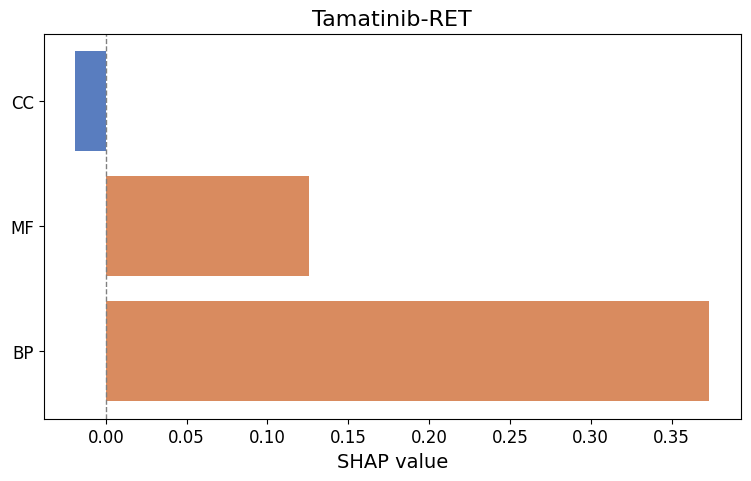

In [8]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [355]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)


print(f'Original Prediction: {y_orig}')
print(f'Mask All Prediction: {y_ma}')
print(f'Mask Front 128 Prediction: {y_m1}')
print(f'Mask Middle 128 Prediction: {y_m2}')
print(f'Mask Last 128 Prediction: {y_m3}')
print(f'Keep Front 128 Prediction: {y_k1}')
print(f'Keep Middle 128 Prediction: {y_k2}')
print(f'Keep Last 128 Prediction: {y_k3}')

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-RET')

initalizing davis test dataset...
generating similarity graph...
Original Prediction: 6.75516939163208
Mask All Prediction: 6.272060394287109
Mask Front 128 Prediction: 6.378223896026611
Mask Middle 128 Prediction: 6.612013339996338
Mask Last 128 Prediction: 6.73259162902832
Keep Front 128 Prediction: 6.6471028327941895
Keep Middle 128 Prediction: 6.386011123657227
Keep Last 128 Prediction: 6.2168121337890625
[0.2081296443939209, 0.05857491493225098, -0.007330656051635742]


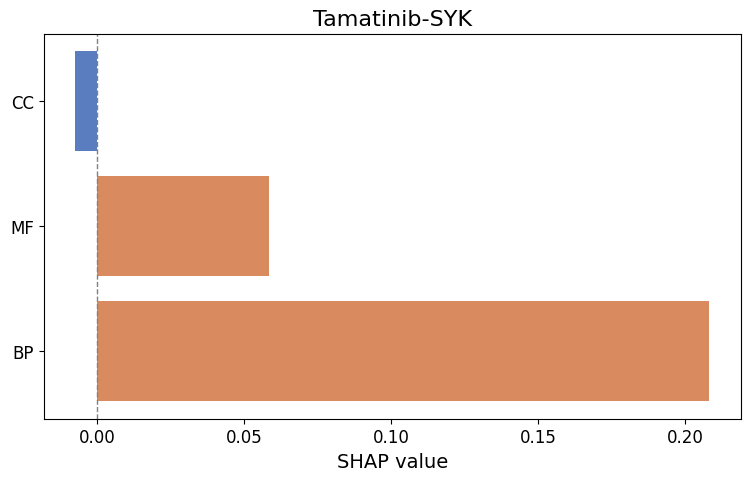

In [9]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [399]  


print(f'Original Prediction: {y_orig}')
print(f'Mask All Prediction: {y_ma}')
print(f'Mask Front 128 Prediction: {y_m1}')
print(f'Mask Middle 128 Prediction: {y_m2}')
print(f'Mask Last 128 Prediction: {y_m3}')
print(f'Keep Front 128 Prediction: {y_k1}')
print(f'Keep Middle 128 Prediction: {y_k2}')
print(f'Keep Last 128 Prediction: {y_k3}')



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-SYK')

initalizing davis test dataset...
generating similarity graph...
Original Prediction: 6.685312271118164
Mask All Prediction: 6.423520565032959
Mask Front 128 Prediction: 6.507783889770508
Mask Middle 128 Prediction: 6.660632133483887
Mask Last 128 Prediction: 6.693631649017334
Keep Front 128 Prediction: 6.667087078094482
Keep Middle 128 Prediction: 6.5208258628845215
Keep Last 128 Prediction: 6.422014236450195
[0.26666080951690674, 0.02851688861846924, -0.1353682279586792]


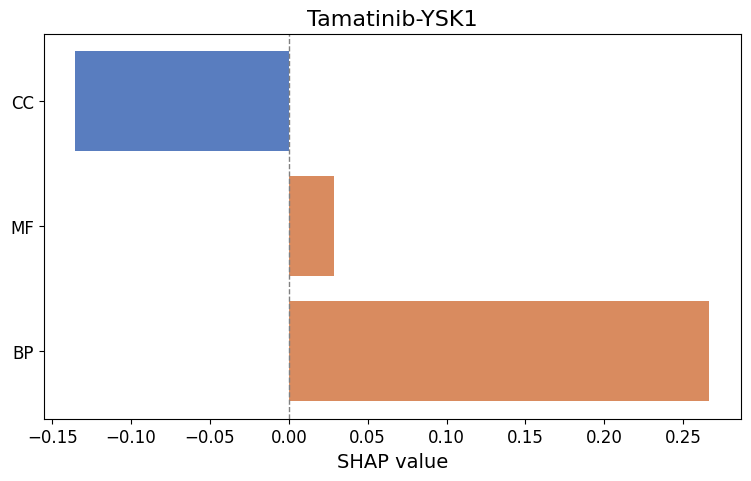

In [10]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [438]  


print(f'Original Prediction: {y_orig}')
print(f'Mask All Prediction: {y_ma}')
print(f'Mask Front 128 Prediction: {y_m1}')
print(f'Mask Middle 128 Prediction: {y_m2}')
print(f'Mask Last 128 Prediction: {y_m3}')
print(f'Keep Front 128 Prediction: {y_k1}')
print(f'Keep Middle 128 Prediction: {y_k2}')
print(f'Keep Last 128 Prediction: {y_k3}')



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-YSK1')

initalizing davis test dataset...
generating similarity graph...
[0.41964662075042725, -0.009869694709777832, 0.009392857551574707]


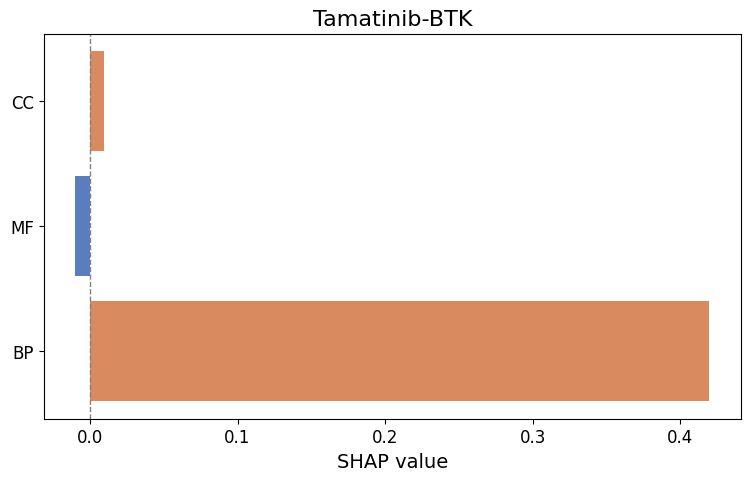

In [11]:

predict = Predict()
predict.predict()



d_index = [47]  
p_index = [49]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-BTK')

initalizing davis test dataset...
generating similarity graph...
[0.1324915885925293, 0.08881497383117676, -0.00918722152709961]


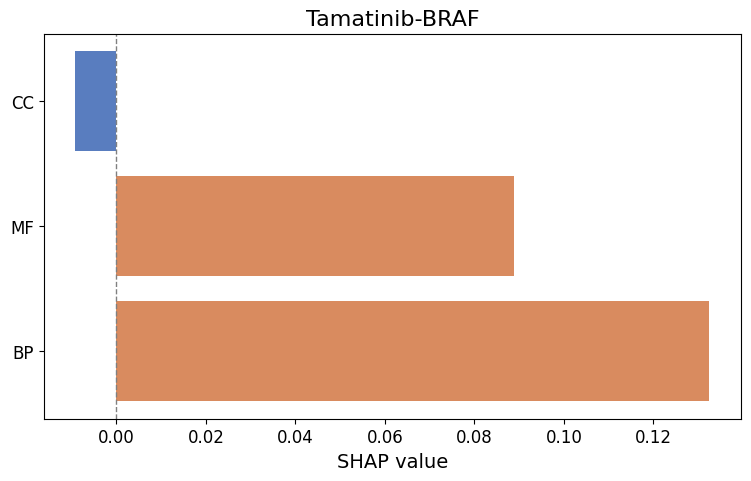

In [12]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [44]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-BRAF')

initalizing davis test dataset...
generating similarity graph...
[-0.04005587100982666, -0.01672041416168213, -0.01391613483428955]


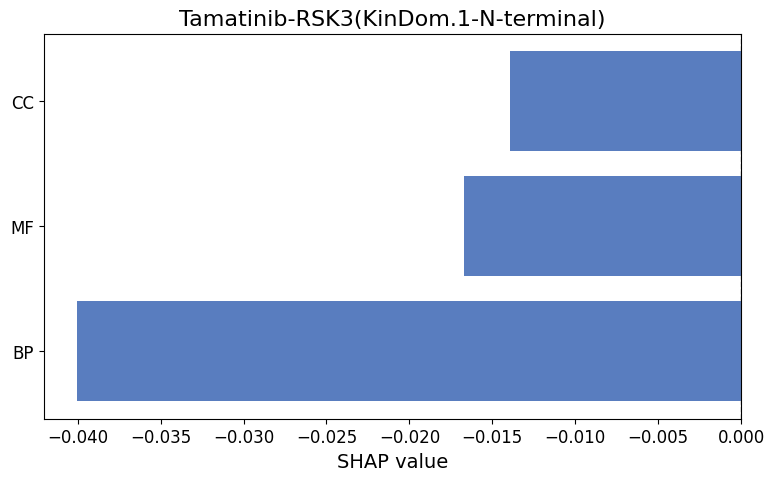

In [13]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [376]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-RSK3(KinDom.1-N-terminal)')

initalizing davis test dataset...
generating similarity graph...
[0.31089890003204346, 0.12131345272064209, 0.042327284812927246]


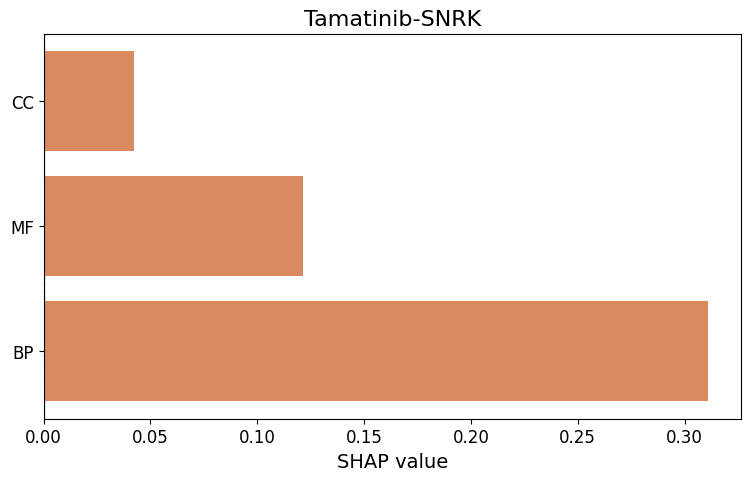

In [14]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [350]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-SNRK')

initalizing davis test dataset...
generating similarity graph...
[0.25858068466186523, -0.12839031219482422, -0.03836870193481445]


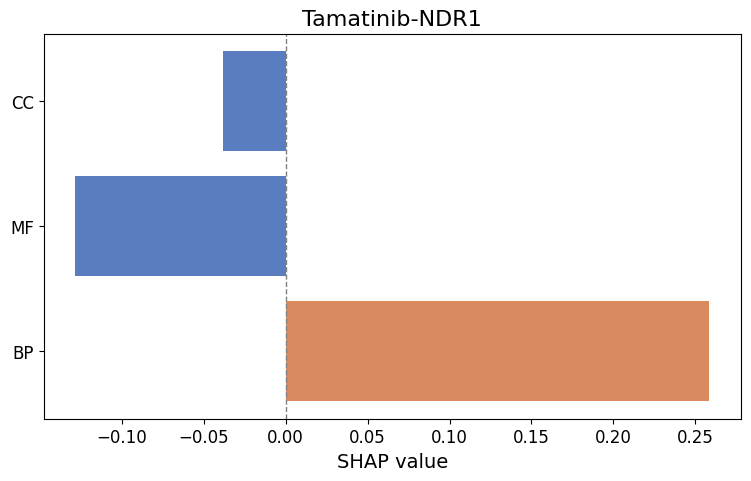

In [15]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [270]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-NDR1')

initalizing davis test dataset...
generating similarity graph...
[0.16741180419921875, -0.02691054344177246, -0.03565573692321777]


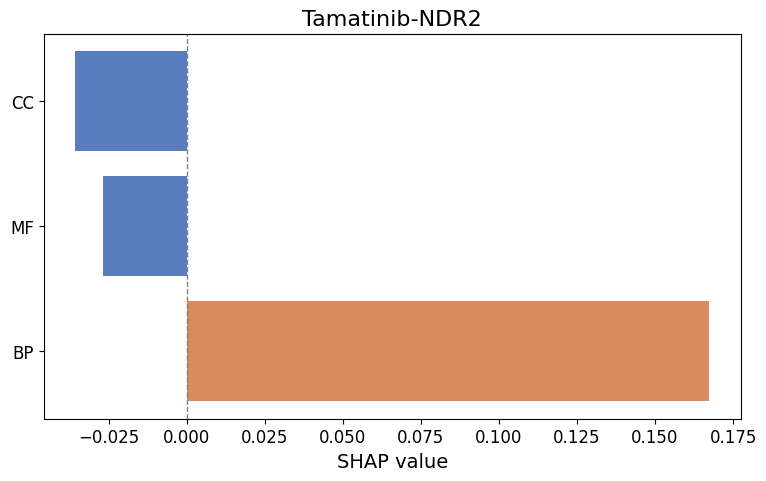

In [16]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [271]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-NDR2')

initalizing davis test dataset...
generating similarity graph...
[0.3634033203125, 0.10179710388183594, -0.014417171478271484]


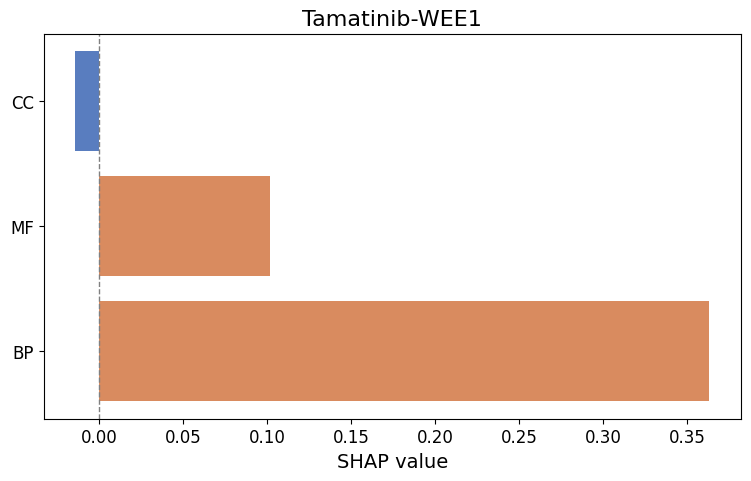

In [17]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [432]  



y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-WEE1')

initalizing davis test dataset...
generating similarity graph...
[-0.02083289623260498, -0.015556693077087402, -0.0370556116104126]


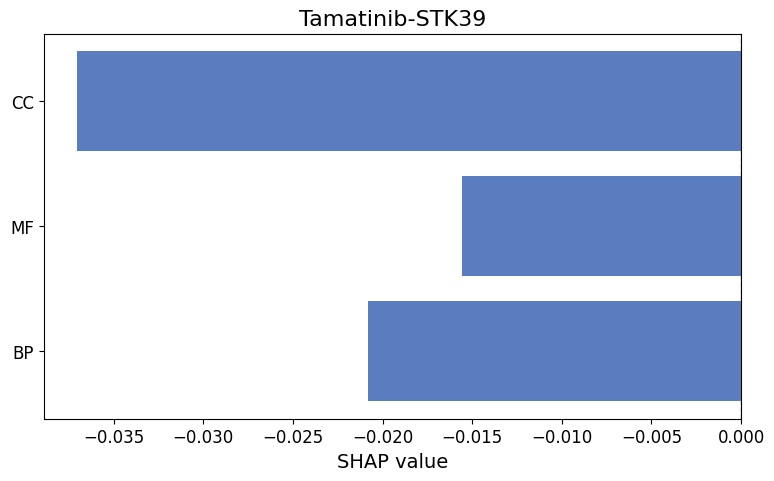

In [18]:
predict = Predict()
predict.predict()



d_index = [47]  
p_index = [398]  

y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Tamatinib-STK39')

In [3]:
predict = Predict()
predict.predict()



d_index = [4]  
p_index = [112]  

y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Afatinib-EGFR')

NameError: name 'Predict' is not defined

initalizing davis test dataset...
generating similarity graph...
[-0.0566638708114624, 0.00520932674407959, 0.014058470726013184]


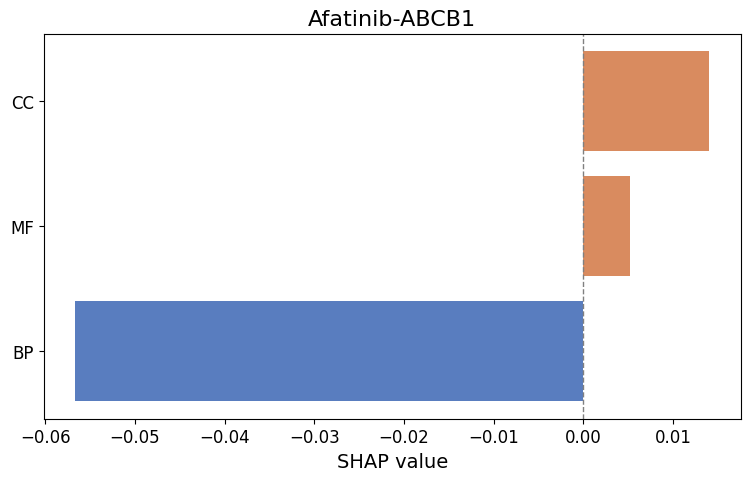

In [67]:
predict = Predict()
predict.predict()



d_index = [4]  
p_index = [140]  

y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Afatinib-ABCB1')

initalizing davis test dataset...
generating similarity graph...
[0.11223089694976807, 0.02085268497467041, 0.017104029655456543]


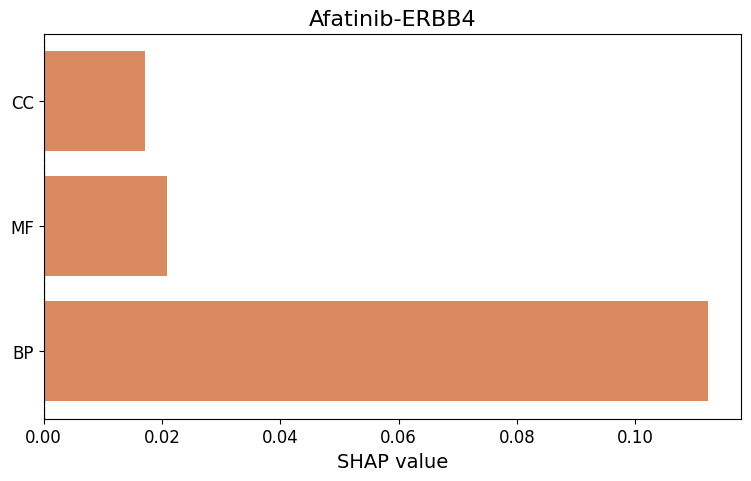

In [68]:
predict = Predict()
predict.predict()



d_index = [4]  
p_index = [138]  

y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Afatinib-ERBB4')

initalizing davis test dataset...
generating similarity graph...
[-0.041727542877197266, -0.009640693664550781, -0.00021505355834960938]


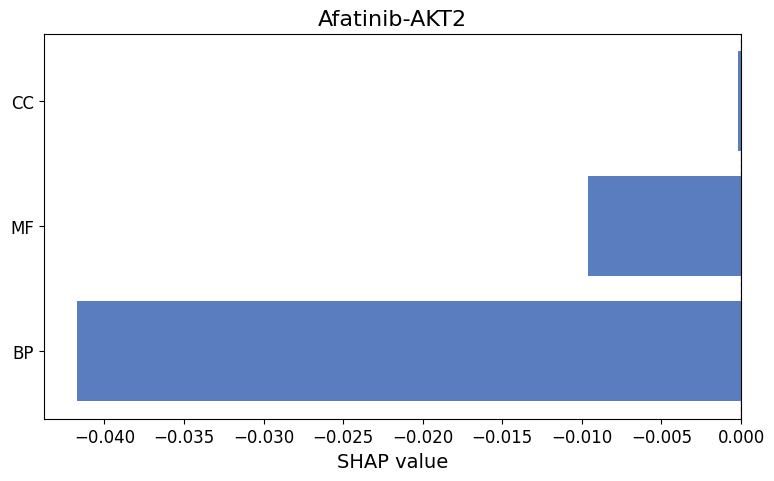

In [69]:
predict = Predict()
predict.predict()



d_index = [4]  
p_index = [25]  

y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig = predict.test_masking_effect(d_index, p_index)

shap_values = calculate_and_plot_shap_values(y_ma, y_k1, y_k2, y_k3, y_m3, y_m2, y_m1, y_orig, title='Afatinib-AKT2')